In [23]:
!pip install medmnist

In [24]:
from fastai.vision.all import *
from fastai import *
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms
from fastai.data.external import *

In [25]:
data_flag = 'octmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [26]:
DataClass=getattr(medmnist, info['python_class'])

In [27]:
train_dataset= DataClass(split='train',download=download)
val_dataset=DataClass(split='val',download=download)
test_dataset=DataClass(split='test',download=download)

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [28]:
data={'Image':[],"Labels":[],"is_valid":[]}

In [29]:
for i in range(len(train_dataset)):
  data['Image'].append(train_dataset[i][0])
  data['Labels'].append(train_dataset[i][1][0])
  data['is_valid'].append(True)

for i in range(len(val_dataset)):
  data['Image'].append(val_dataset[i][0])
  data['Labels'].append(val_dataset[i][1][0])
  data['is_valid'].append(False)

In [30]:
train_df=pd.DataFrame.from_dict(data)
train_df

,Image,Labels,is_valid
0,<PIL.Image.Image image mode=L size=28x28>,0,True
1,<PIL.Image.Image image mode=L size=28x28>,3,True
2,<PIL.Image.Image image mode=L size=28x28>,3,True
3,<PIL.Image.Image image mode=L size=28x28>,3,True
4,<PIL.Image.Image image mode=L size=28x28>,0,True
...,...,...,...
108304,<PIL.Image.Image image mode=L size=28x28>,0,False
108305,<PIL.Image.Image image mode=L size=28x28>,3,False
108306,<PIL.Image.Image image mode=L size=28x28>,0,False
108307,<PIL.Image.Image image mode=L size=28x28>,0,False


In [31]:
train_df=train_df.sample(frac = 1).reset_index(drop=True)
train_df

,Image,Labels,is_valid
0,<PIL.Image.Image image mode=L size=28x28>,0,True
1,<PIL.Image.Image image mode=L size=28x28>,3,False
2,<PIL.Image.Image image mode=L size=28x28>,1,True
3,<PIL.Image.Image image mode=L size=28x28>,3,True
4,<PIL.Image.Image image mode=L size=28x28>,3,True
...,...,...,...
108304,<PIL.Image.Image image mode=L size=28x28>,0,True
108305,<PIL.Image.Image image mode=L size=28x28>,0,False
108306,<PIL.Image.Image image mode=L size=28x28>,3,True
108307,<PIL.Image.Image image mode=L size=28x28>,0,True


In [32]:
def get_x(r):
    img=r['Image']
    img=np.asarray(img)
    return (img).astype(np.uint8)

def get_y(r):
    return r["Labels"]

In [33]:
switch=True
block=""
if n_channels==1 and switch:
  block=(ImageBlock(cls=PILImageBW), CategoryBlock) 
else:
  block=(ImageBlock(), CategoryBlock)

dblock = DataBlock(
    blocks=block,
    get_x=get_x,
    get_y=get_y,
    splitter=ColSplitter()
)

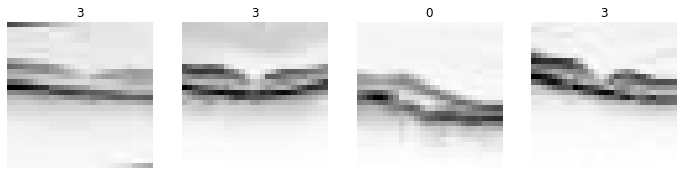

In [34]:
dls = dblock.dataloaders(train_df, bs=32, device=torch.device('cuda'))
dls.show_batch(nrows=1, ncols=4)

In [35]:
learn = vision_learner(dls, resnet101, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [36]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)  

epoch,train_loss,valid_loss,accuracy,time
0,1.579063,60.520985,0.594099,02:58
1,1.128080,8.145110,0.656699,02:58
2,0.958548,1.251786,0.692522,02:59
3,0.909434,3.622066,0.716549,03:00


epoch,train_loss,valid_loss,accuracy,time
0,0.739446,0.939010,0.793397,03:07
1,0.564635,0.612739,0.830463,03:07
2,0.390364,0.646963,0.836987,03:08


In [41]:
learn.metrics = accuracy
learn.validate() #(loss,accuracy)(for validation)

(#2) [0.6469632983207703,0.8369871973991394]

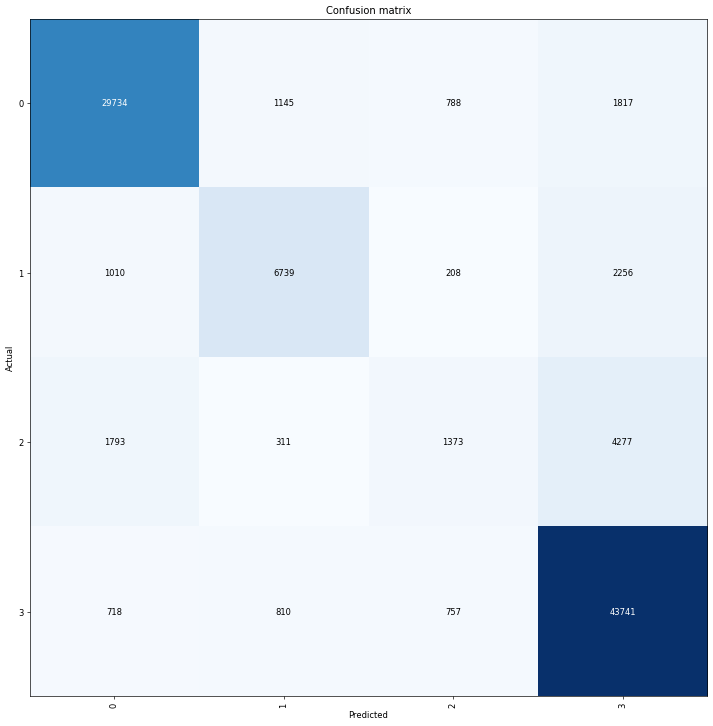

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # confusion matrix

In [43]:
predictions=[]
labels=[]
for i in range(len(test_dataset)):
  img=np.asarray(test_dataset[i][0])
  img=(img).astype(np.uint8)
  pred,_,probs=learn.predict(img)
  predictions.append(int(pred))
  labels.append(test_dataset[i][1][0])

In [44]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.54      0.90      0.68       250
           1       0.86      0.68      0.76       250
           2       0.80      0.03      0.06       250
           3       0.63      0.94      0.75       250

    accuracy                           0.64      1000
   macro avg       0.71      0.64      0.56      1000
weighted avg       0.71      0.64      0.56      1000

